In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [2]:
prices = pd.read_csv('data/log_prices.csv', index_col='date')
prices = prices.dropna()
prices.head()

,brn,cl,ho,xrb
date,,,,
20150105,0.010676,0.025528,-0.023495,0.032481
20150112,-0.039646,-0.081290,-0.008362,-0.018356
20150119,0.082589,0.041151,0.022561,0.087349
20150126,0.117570,0.118920,0.091463,0.075879
20150202,0.056883,0.012610,0.069970,0.039044


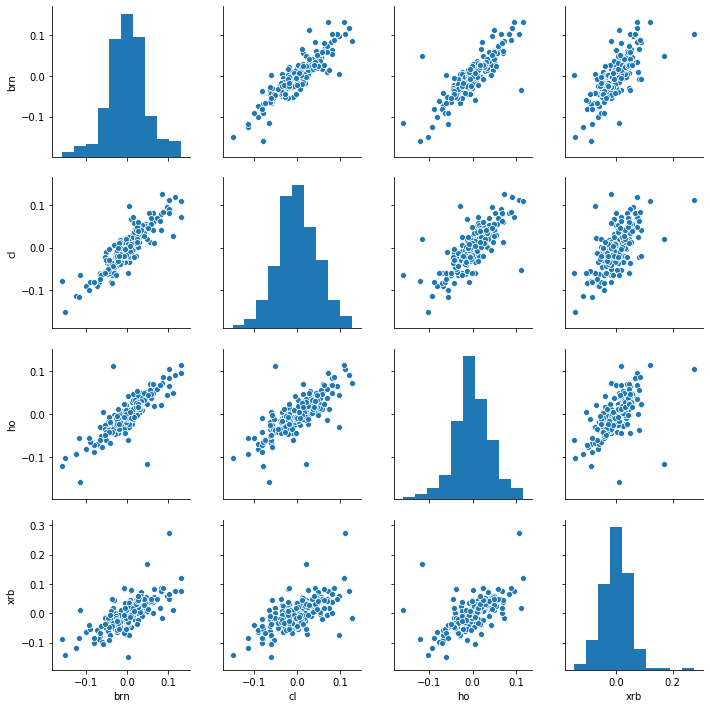

In [3]:
sb.pairplot(prices)
plt.show()

Empirical correlation

In [4]:
prices.corr()

,brn,cl,ho,xrb
brn,1.000000,0.890081,0.846233,0.719229
cl,0.890081,1.000000,0.778133,0.658417
ho,0.846233,0.778133,1.000000,0.620990
xrb,0.719229,0.658417,0.620990,1.000000


## Copula

Modeling of a copula. Given a random vector $(X_1, \dots, X_d)$, the copula is defined as

$$C(u_1, \dots, u_n) = \mathbb P(X_1 \leq F^{-1}_1(u_1), \dots, X_d \leq F^{-1}_d(u_d))$$

where $F^{-1}_i$ is a reverse CDF of $X_i$ RV and $u_i$ is a random realization from a uniform $U_i$ RV.

Suppose that these are t-distributions. Fit parameters of marginal distributions.

In [5]:
param = {'brn': stats.t.fit(prices.brn), 
         'cl': stats.t.fit(prices.cl), 
         'ho': stats.t.fit(prices.ho), 
         'xrb': stats.t.fit(prices.xrb)}
pd.DataFrame(param, index=['df', 'loc', 'scale']).T

,df,loc,scale
brn,4.717482,0.001396,0.036572
cl,35.155460,0.000365,0.045774
ho,5.572727,0.000280,0.033830
xrb,5.853887,-0.000273,0.040088


Generating 10000 observations from the Normal distribution

In [6]:
cov = np.array(prices.cov())
norm_sample = np.random.multivariate_normal([0, 0, 0, 0], cov, size=10000)

Uniform transformation

In [7]:
unif_sample = []
for i, i_sample in enumerate(norm_sample.T):
    unif_sample.append(stats.norm.cdf(i_sample, loc=0, scale=cov[i][i]**(1/2)))
unif_sample = np.array(unif_sample)

Student's t transformation

In [8]:
df, loc, scale = param['brn']
brn_sample = stats.t.ppf(unif_sample[0], df, loc, scale)

df, loc, scale = param['cl']
cl_sample = stats.t.ppf(unif_sample[1], df, loc, scale)

df, loc, scale = param['ho']
ho_sample = stats.t.ppf(unif_sample[2], df, loc, scale)

df, loc, scale = param['xrb']
xrb_sample = stats.t.ppf(unif_sample[3], df, loc, scale)

gen_prices = pd.DataFrame({'brn': brn_sample, 
                           'cl': cl_sample, 
                           'ho': ho_sample, 
                           'xrb': xrb_sample})

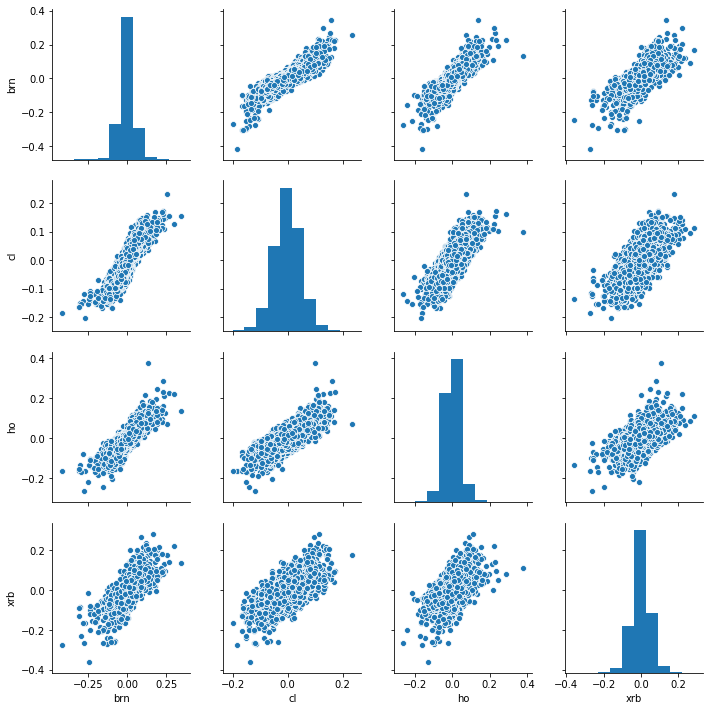

In [9]:
sb.pairplot(gen_prices)
plt.show()

In [10]:
gen_prices.corr()

,brn,cl,ho,xrb
brn,1.000000,0.875611,0.833567,0.701822
cl,0.875611,1.000000,0.769212,0.645162
ho,0.833567,0.769212,1.000000,0.591879
xrb,0.701822,0.645162,0.591879,1.000000


In [11]:
print(stats.t.fit(prices.cl))
print(stats.t.fit(gen_prices.cl))

(35.15545988613356, 0.0003650380447012075, 0.045773879438890136)
(28.726464504404092, -0.0003802900315052724, 0.04523983568847214)


In [12]:
sample = stats.t.rvs(35, 0, 0.5, 200)
stats.t.fit(sample)

(9.339799566389221, -0.03127632246547127, 0.41685287891646255)

## Empirical Copula

Modeling of pseudo copula. Applying of empirical reverse CDF of a t-distribution CDF:

$$\hat F_X(x) = R_X(x) = \frac{1}{n }\sum_i^n \mathbb 1\{x_i<x\}$$

In [13]:
cov = np.array(prices.cov())
norm_sample = np.random.multivariate_normal([0, 0, 0, 0], cov, size=10000)
unif_sample = []
for i, i_sample in enumerate(norm_sample.T):
    unif_sample.append(stats.norm.cdf(i_sample, loc=0, scale=cov[i][i]**(1/2)))
unif_sample = np.array(unif_sample)

brn_sample = np.quantile(prices.brn, unif_sample[0])
cl_sample = np.quantile(prices.cl, unif_sample[1])
ho_sample = np.quantile(prices.ho, unif_sample[2])
xrb_sample = np.quantile(prices.xrb, unif_sample[3])
gen_prices = pd.DataFrame({'brn': brn_sample, 
                           'cl': cl_sample, 
                           'ho': ho_sample, 
                           'xrb': xrb_sample})

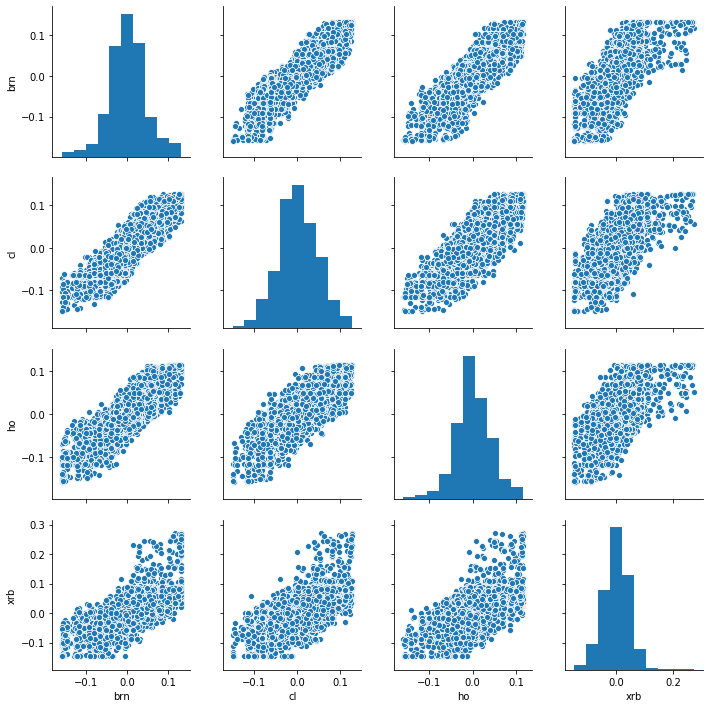

In [14]:
sb.pairplot(gen_prices)
plt.show()

In [15]:
gen_prices.corr()

,brn,cl,ho,xrb
brn,1.000000,0.881498,0.845289,0.699910
cl,0.881498,1.000000,0.775958,0.642056
ho,0.845289,0.775958,1.000000,0.607674
xrb,0.699910,0.642056,0.607674,1.000000
